In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax 
import jax.numpy as jnp     

At epoch = 0, loss = 0.036181
At epoch = 200, loss = 0.011888
At epoch = 400, loss = 0.009780
At epoch = 600, loss = 0.008924
At epoch = 800, loss = 0.008573
After training (JAX/SGD), the predicted theta is a = 1.509, β = 0.319, ω = 9.885, δ = 0.297


'Note that the loss asymptotes to ~ 8e-3 (good fit) but does not reach 0 due to noise in the data (not an exact DHO signal).'

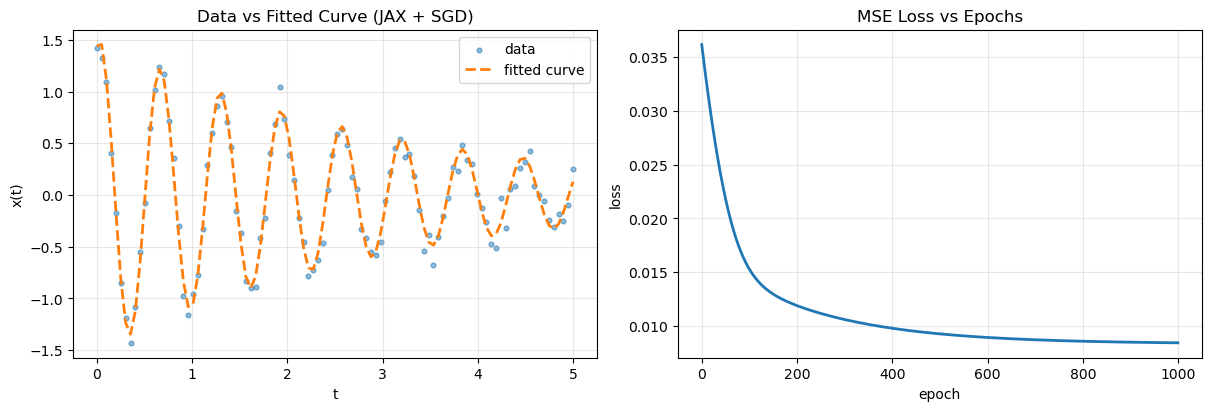

In [ ]:
# 1 (single-layer NN for parameter inference using SGD in JAX)
# - N: number of noisy samples from the damped harmonic oscillator (batch size B = N)
# - times  ∈ R^{N}  # scalar input per sample (d_in = 1)
# - x_data ∈ R^{N}  # scalar target per sample (d_out = 1)
# batched shapes are (N,) (1D vectors) instead of (N,1) = (B, d_in = d_out); this is fine here since d_in = d_out = 1.
num_samples = 100
time_end = 5.0
times  = np.linspace(0.0, time_end, num_samples)     
x_data = np.array([ 1.42136407e+00,  1.32538052e+00,  1.08997205e+00,  4.01375320e-01,
       -1.78495795e-01, -8.50696683e-01, -1.18615104e+00, -1.42918430e+00,
       -1.08653056e+00, -5.51030603e-01, -7.50736710e-02,  6.47062767e-01,
        1.01484947e+00,  1.23909135e+00,  1.16973363e+00,  7.14521669e-01,
        3.55287429e-01, -2.95169206e-01, -9.74425168e-01, -1.16492314e+00,
       -9.52631079e-01, -7.77656938e-01, -3.28057458e-01,  2.92744065e-01,
        6.01953380e-01,  8.65371671e-01,  9.54240091e-01,  7.08483475e-01,
        4.68455172e-01, -1.56245101e-01, -3.70602686e-01, -8.30733462e-01,
       -8.95167164e-01, -8.91137955e-01, -4.18014142e-01, -2.22376053e-01,
        4.10047775e-01,  6.88406843e-01,  1.04061990e+00,  7.30025281e-01,
        3.90618018e-01,  1.43181366e-01, -2.20778546e-01, -4.53298514e-01,
       -7.87562022e-01, -7.21285197e-01, -6.27664217e-01, -4.65873073e-01,
        4.76786963e-02,  3.89328316e-01,  5.92877625e-01,  6.37519856e-01,
        4.83785342e-01,  1.71821980e-01,  5.43082539e-02, -3.29509591e-01,
       -4.12974420e-01, -5.53475010e-01, -5.83206553e-01, -4.58252882e-01,
       -5.48980467e-02,  2.26195369e-01,  4.52451610e-01,  5.38430311e-01,
        3.67845822e-01,  3.97176254e-01,  1.84432283e-01, -1.49708735e-01,
       -5.37683940e-01, -3.88877197e-01, -6.79843289e-01, -4.05592818e-01,
       -2.06048677e-01, -3.04612159e-02,  2.73534969e-01,  2.33194682e-01,
        4.87619039e-01,  3.34767833e-01,  3.00019677e-01,  9.12268252e-03,
       -1.21252257e-01, -2.57336778e-01, -4.68953016e-01, -5.12673830e-01,
       -2.89839003e-02, -3.22855227e-01,  5.86021068e-02,  8.32512072e-02,
        2.60554538e-01,  3.23171785e-01,  4.29277758e-01,  8.75180664e-02,
       -1.17562189e-03, -5.57391100e-02, -2.43060644e-01, -3.07899430e-01,
       -1.78936431e-01, -2.53676100e-01, -9.54204646e-02,  2.55114941e-01], dtype=jnp.float32)

# single-layer parametric fit: f(t; θ) = a * exp(-β t) * cos(ω t - δ) = x̂
# learnable parameters: θ = (a, β, ω, δ) ∈ R^{4}  → stored as a 1D array of shape (4,)
def f(theta, t):
    a, beta, omega, delta = theta
    return a * jnp.exp(-beta*t) * jnp.cos(omega*t - delta)

def initial_parameters():
    return jnp.array([1.5, 0.5, 10.0, 0.5]) # reasonable initial guess for θ = (a, β, ω, δ)

# MSE loss over the full batch
def mse(theta, t, x):
    return jnp.mean((f(theta, t) - x)**2)

# one SGD step over the full batch 
@jax.jit
def sgd_step(theta, t, x, lr):
    loss, grads = jax.value_and_grad(mse)(theta, t, x)
    theta = theta - lr * grads
    return theta, loss

theta = initial_parameters()
lr = 1e-2
sgd_losses = []
num_epochs = 1000

for epoch in range(num_epochs):
    theta, loss = sgd_step(theta, times, x_data, lr)
    if epoch % (num_epochs // 5) == 0:
        print(f"At epoch = {epoch}, loss = {loss:.6f}")
    sgd_losses.append(loss)

fig, axs = plt.subplots(1,2, figsize = (12,4), constrained_layout=True)
x_fit = f(theta, times)

axs[0].scatter(times, x_data, s=12, alpha=0.5, label="data")
axs[0].set_title("Data vs Fitted Curve (JAX + SGD)")
axs[0].plot(times, x_fit, '--', color = 'C1', lw=2, label="fitted curve")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x(t)")
axs[0].legend()
axs[0].grid(alpha=0.3)

epochs = jnp.arange(num_epochs) # 0, 1, 2, ..., num_epochs-1
axs[1].plot(epochs, sgd_losses, lw=2) 
axs[1].set_title("MSE Loss vs Epochs")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
axs[1].grid(alpha=0.3)

print(f"After training (JAX/SGD), the predicted theta is a = {theta[0]:.3f}, β = {theta[1]:.3f}, ω = {theta[2]:.3f}, δ = {theta[3]:.3f}")
'Note that the loss asymptotes to ~ 8e-3 (good fit) but does not reach 0 due to noise in the data (not an exact DHO signal).'

T =  3
<E>/N =  -0.76576
<E^2>/N =  0.6119296
<M>/N =  0.2261
<M^2>/N =  0.0839468
C= 0.0028379136000000007
chi= 0.010941863333333334
Acceptance ratio =  0.004763333333333333


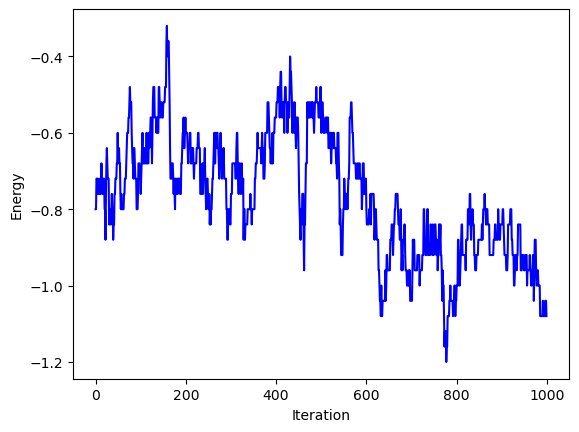

In [ ]:
# 2.1 (Monte Carlo samples from 2D Ising model)

class Direction:
    RIGHT, TOP, LEFT, BOTTOM = range(4)
    # Integer codes for the 4 cardinal directions on the 2D lattice 
    # Used as indices into the neighbor table self.nn[n, dir]:
    #   RIGHT  = 0  → neighbor at (x+1, y)
    #   TOP    = 1  → neighbor at (x,   y+1)
    #   LEFT   = 2  → neighbor at (x-1, y)
    #   BOTTOM = 3  → neighbor at (x,   y-1)

class Ising:
    
    def __init__(self, L, J, T):
        # L : linear lattice size → total spins N = L×L
        # J : nearest-neighbor coupling (energy scale, ferromagnetic if J > 0)
        # T : temperature (in units where k_B = 1, so β = 1/T)
        self.L = L
        self.N = L * L
        self.TWOJ = 2.0 * J # precompute 2J for Metropolis energy changes
        self.T = T
        self.beta = 1.0 / T    

        # spins live on an L×L lattice: spin_lattice[iy, ix] = s_{iy,ix} ∈ {+1, -1} (y along rows, x along columns)
        # , but are stored in a 1D array self.spin of length N = L*L (n = 0, . . . , N-1).
        # self.nn is the nearest-neighbor (NN) table: for each site index n and direction dir, self.nn[n, dir] = flat index of the neighbor of n in that direction.
        #
        # With PBC in x and y, edges wrap around (torus geometry).
        self.nn = np.zeros((self.N, 4), dtype=np.int16)   # NN indices for each n
        self.position = np.zeros((L, L), dtype=np.int16)  # (iy, ix) → n
        self.x = np.zeros(self.N, dtype=np.int16)         # n → ix
        self.y = np.zeros(self.N, dtype=np.int16)         # n → iy

        n = 0
        for iy in range(L):
            for ix in range(L):
                self.position[iy, ix] = n
                self.x[n] = ix
                self.y[n] = iy

                # naive neighbors
                self.nn[n, Direction.LEFT]   = n - 1
                self.nn[n, Direction.RIGHT]  = n + 1
                self.nn[n, Direction.TOP]    = n + L
                self.nn[n, Direction.BOTTOM] = n - L

                # fix edges for periodic wrap-around
                if ix == 0:
                    self.nn[n, Direction.LEFT] = n + L - 1
                if ix == L - 1:
                    self.nn[n, Direction.RIGHT] = n - (L - 1)
                if iy == 0:
                    self.nn[n, Direction.BOTTOM] = n + (L - 1) * L
                if iy == L - 1:
                    self.nn[n, Direction.TOP] = n - (L - 1) * L

                n += 1


        # Initialize spins
        r = np.random.random(self.N)*2-1
        self.spin = np.ones(self.N, dtype=np.int16)
        for i in range(self.N):
            if(r[i] < 0):
                self.spin[i] *= -1
                
        self.Mtot = np.sum(self.spin)
        self.E = 0.
        for i in range(self.N):
            self.E += -J*self.spin[i]*(self.spin[self.nn[i,Direction.RIGHT]]+self.spin[self.nn[i,Direction.TOP]])

        # Transition probabilities
        self.de = np.zeros(shape=(3,9)) # spins -1 and 1 only, but choose 3 to index as below. 9 = range of spin_sum, -4 . . . 4
        self.w = np.zeros(shape=(3,9))
        self.set_temp(self.T)
                                                             
    def set_temp(self, T):
        self.T = T
        self.beta = 1./T
        # Lookup tables for transition probabilities
        for spin_sum in range(-4,5):
            self.de[0,spin_sum+4] = -self.TWOJ*spin_sum
            self.de[2,spin_sum+4] = self.TWOJ*spin_sum
            p = np.exp(-self.beta*self.de[0,spin_sum+4])
            self.w[0,spin_sum+4] = min(p, 1.)
            self.w[2,spin_sum+4] = min(1./p,1.)
                                                             
    def metropolis(self):
        nchanges = 0
        if True: # for n in range(self.N):
            # trial spin change
            # pick a random particle
            i = int(np.random.random()*self.N)

            # change in energy
            iright = self.nn[i, Direction.LEFT]
            ileft = self.nn[i, Direction.RIGHT]
            itop = self.nn[i, Direction.TOP]
            ibottom = self.nn[i, Direction.BOTTOM]

            spin_sum = self.spin[ileft] + self.spin[iright] + self.spin[itop] + self.spin[ibottom]

            s = self.spin[i]
            deltaE = self.de[s+1,spin_sum+4]

            # accept if lowers energy or random num below w
            if(deltaE <= 0. or np.random.random() < self.w[s+1,spin_sum+4]):
                self.spin[i] *= -1
                self.Mtot += 2*(-s)
                self.E += deltaE
                nchanges += 1

        return nchanges

L=10
Nwarmup = 100
Nsteps = 1000
Ndecorr = 3
Temp = 3
J = 1.

S = Ising(L, J, Temp)
E = np.zeros(Nsteps)
M = np.zeros(Nsteps)

for i in range(Nwarmup):
    S.metropolis()

naccept = 0
for i in range(Nsteps):
    for n in range(Ndecorr):
        naccept += S.metropolis()
    E[i] = S.E
    M[i] = abs(S.Mtot)

E /= S.N
M /= S.N


Et = np.sum(E)/Nsteps
E2t = np.sum(E**2)/Nsteps
Mt = np.sum(M)/Nsteps
M2t = np.sum(M**2)/Nsteps

print("T = ", Temp)
print("<E>/N = ", Et)
print("<E^2>/N = ", E2t)
print("<M>/N = ", Mt)
print("<M^2>/N = ", M2t)
print("C=", (E2t-Et*Et)/Temp/Temp)
print("chi=", (M2t-Mt*Mt)/Temp)
print("Acceptance ratio = ", float(naccept)/S.N/Nsteps/Ndecorr)
        
plt.plot(np.arange(0,Nsteps,1),E,ls='-',c='blue');
plt.xlabel("Iteration")
plt.ylabel("Energy");     


In [ ]:
# 2.2 (CNN to classify samples as ordered or disordered)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu") 

# package raw data by inheriting from Data
class IsingDataset(Dataset):

    def __init__(self, configs, labels, transform=None, target_transform=None):
        super().__init__()
        self.configs = torch.as_tensor(configs, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.int64)

        if self.configs.ndim == 3:          # (N, L, L)
            self.configs = self.configs.unsqueeze(1)  # → (N, 1, L, L)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.configs.shape[0]
    
    def __getitem__(self, idx):

        x = self.configs[idx]
        y = self.labels[idx]
        
        if self.transform is not None:
            x = self.transform(x)
        if self.target_transform is not None:
            y = self.transform(y)

        return x, y
    

# set up training and testing loaders
ising_configs, ising_labels = None

train_percent = 0.9
test_percent = 0.1

data_set = IsingDataset(ising_configs, ising_labels) 
train_set, test_set = torch.utils.data.random_split(data_set, [train_percent, test_percent] ) # 90/10 test train split

B = 1

# iterable over batches X_b, Y_b 
trainloader = DataLoader(train_set, batch_size=B, shuffle=True)
testloader = DataLoader(test_set, batch_size=B, shuffle=False)


# model


# helper function to compute the output dimension after a convolution
def get_out_dim(size, kernel, stride, padding, dilation):
    return int(np.floor((size+2*padding-dilation*(kernel-1)-1)/stride + 1))

class CNN_classifier(nn.Module):

    def __init__(self, in_dim, in_channels, out_channels_1, out_channels_2, conv_kernel_size, pool_kernel_size, conv_stride, pool_stride, conv_padding, pool_padding, conv_dilation, pool_dilation, groups):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels_1, conv_kernel_size, conv_stride, conv_padding, conv_dilation, groups)
        self.pool = nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding, pool_dilation)
        self.conv2 = nn.Conv2d(out_channels_1, out_channels_2, conv_kernel_size, conv_stride, conv_padding, conv_dilation, groups)

        out_dim_1 = get_out_dim(in_dim, conv_kernel_size, conv_stride, conv_padding, conv_dilation)
        out_dim_2 = get_out_dim(out_dim_1, pool_kernel_size, pool_stride, pool_padding, pool_dilation)
        out_dim_3 = get_out_dim(out_dim_2, conv_kernel_size, conv_stride, conv_padding, conv_dilation)
        out_dim_4 = get_out_dim(out_dim_3, pool_kernel_size, pool_stride, pool_padding, pool_dilation)

   
        self.fc1 = nn.Linear(out_channels_2 * out_dim_4 * out_dim_4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 2)

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

# hyperparameters
num_epochs = 25
learning_rate = 1e-2
weight_decay = 1e-2

# model, loss, optimizer

model = CNN_classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay) # decoupled L2 regularization
 
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # dataset attribiute of dataloader = dataset 
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader): # batch = counter of for each iterable
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * X.shape[0] + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs+1): 
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(trainloader, model, loss_fn, optimizer)
    test_loop(testloader, model, loss_fn)
print("Done!")

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# 2.3 (detecting critical temperature)

